#  Variational Inference

In [260]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter

import seaborn as sns

from swag import data, models, utils, losses
from swag.posteriors import SWAG

import tqdm

import os
import math

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

import hamiltorch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


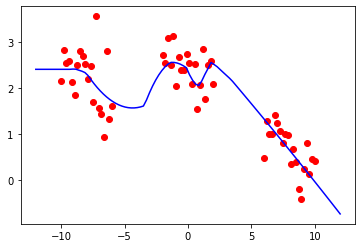

In [261]:
def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)
        


arr = np.load("data.npz") 
x = torch.from_numpy(arr['x'])
f = featurize(x)
y = torch.from_numpy(arr['y']) * 10

x_ = torch.from_numpy(arr['x_'])
f_ = featurize(x_)
y_ = torch.from_numpy(arr['y_']) * 10

plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), y_.data.numpy(), "-b")

In [262]:
class LinearVI(nn.Module):
    
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super(LinearVI, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mean = Parameter(torch.Tensor(out_features, in_features))
        self.weight_isp_std = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias_mean = Parameter(torch.Tensor(out_features))
            self.bias_isp_std = Parameter(torch.Tensor(out_features))
            self.with_bias = True
        else:
            self.with_bias = False
        self.reset_parameters()
        
        self.eps = 1e-6
        self.pretraining = False
        
    def forward(self, input):
        if self.pretraining:
            return F.linear(input, self.weight_mean, self.bias_mean)
        w_sigma = F.softplus(self.weight_isp_std) + self.eps
        w = self.weight_mean + torch.randn_like(self.weight_mean) * w_sigma
        if self.with_bias:
            b_sigma = F.softplus(self.bias_isp_std) + self.eps
            b = self.bias_mean + torch.randn_like(self.bias_mean) * b_sigma
        else:
            b = None
        return F.linear(input, w, b)
    
    def pretrain(self):
        self.pretraining = True
    
    def finetune(self):
        self.pretraining = False
        
    def reset_parameters(self) -> None:
        torch.nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
        self.weight_isp_std.data.fill_(-3)
        if self.with_bias:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight_mean)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias_mean, -bound, bound)
            self.bias_isp_std.data.fill_(-3)
    
    def _get_kl(self, param_mean, param_isp_std, prior_log_sigma):
        sigma = F.softplus(param_isp_std) + self.eps
        kl = torch.sum(prior_log_sigma - torch.log(sigma) +
                       0.5 * (sigma ** 2) / (math.exp(prior_log_sigma * 2)))
        kl += 0.5 * torch.sum(param_mean ** 2) / math.exp(prior_log_sigma * 2)
        return kl
    
    def kl_with_prior(self, prior_log_sigma):
        w_kl = self._get_kl(self.weight_mean, self.weight_isp_std, prior_log_sigma)
        if self.with_bias:
            b_kl = self._get_kl(self.bias_mean, self.bias_isp_std, prior_log_sigma)
            return w_kl + b_kl
        else:
            return w_kl

In [263]:

class RegNetVI(nn.Sequential):
    def __init__(self, dimensions, input_dim=1, output_dim=1, apply_var=True):
        super(RegNetVI, self).__init__()
        self.dimensions = [input_dim, *dimensions, output_dim]        
        for i in range(len(self.dimensions) - 1):
            self.add_module('linear%d' % i, LinearVI(self.dimensions[i], self.dimensions[i + 1]))
            if i < len(self.dimensions) - 2:
                self.add_module('relu%d' % i, torch.nn.ReLU())
                
    def pretrain(self):
        for module in self:
            if isinstance(module, LinearVI):
                module.pretrain()
    
    def finetune(self):
        for module in self:
            if isinstance(module, LinearVI):
                module.finetune()

In [264]:
n_steps = 3000

net = RegNetVI(dimensions=[10, 10, 10], input_dim=2)
net.pretrain()

optimizer = torch.optim.SGD(net.parameters(), lr=5e-6)
criterion = torch.nn.functional.mse_loss
noise_var = 0.0005
prior_var = 100

for epoch in range(n_steps):
    optimizer.zero_grad()
    preds = net(f)
    loss = criterion(preds, y) / (2 * noise_var)
    loss.backward()
    optimizer.step()

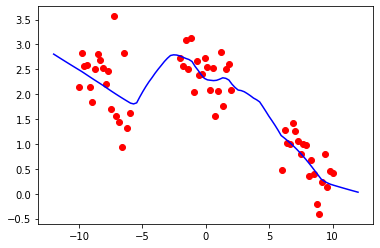

In [265]:
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), net(f_).data.numpy(), "-b")

## VI

In [266]:
def compute_kl_term(net, prior_log_sigma):
    kl = 0.
    for module in net:
        if isinstance(module, LinearVI):
            kl += module.kl_with_prior(prior_log_sigma)
    return kl

In [276]:
n_steps = 10000
prior_var = 0.1

net.finetune()
# net.pretrain()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-5)
criterion = torch.nn.functional.mse_loss
noise_var = 0.0005

for epoch in tqdm.tqdm(range(n_steps)):
    optimizer.zero_grad()
    preds = net(f)
    loss = criterion(preds, y) / (2 * noise_var)
    loss += compute_kl_term(net, prior_log_sigma=np.log(prior_var) / 2) / len(y)
    loss.backward()
    optimizer.step()

100%|██████████| 10000/10000 [00:22<00:00, 450.27it/s]


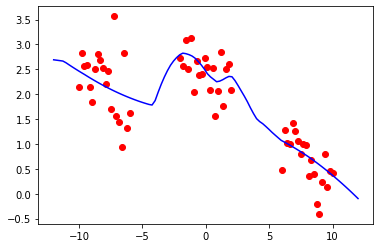

In [279]:
# net.pretrain()
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), net(f_).data.numpy(), "-b")

In [219]:
optimizer.zero_grad()
# loss = 0.5 * torch.sum(net[0].weight_mean**2) + 0.5 * torch.sum(net[2].weight_mean**2)
# loss = net[0].kl_with_prior(1.) + net[6].kl_with_prior(1.) + net[2].kl_with_prior(1.) + net[4].kl_with_prior(1.)
loss = compute_kl_term(net, prior_log_sigma=np.log(prior_var) / 2) #/ len(y)
loss.backward()

In [249]:
# for module in net:
#     if isinstance(module, LinearVI):
#         print(module.weight_mean, F.softplus(module.weight_isp_std))
# #         print(module.weight_mean, module.weight_mean.grad)#, module.weight_mean.grad / module.weight_mean)
# #         print(module.bias_mean, module.bias_mean.grad)

In [280]:
all_preds = np.vstack([net(f_)[None, :].data.numpy() for _ in range(100)])

(-1, 4)

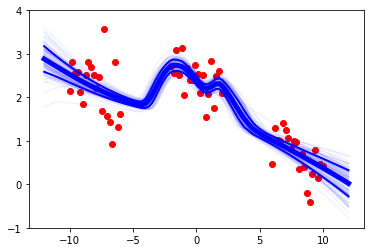

In [281]:
# all_preds = np.vstack([np.load("preds_de_{}.npy".format(i)) for i in range(n_ens)])
# all_preds = np.load("deep_ensembles_preds.npy")[:]
pred_mean = all_preds.mean(axis=0)
pred_std = all_preds.std(axis=0)
pred_upper = pred_mean + pred_std
pred_lower = pred_mean - pred_std

plt.plot(x.data.numpy(), y.data.numpy(), "ro")
# plt.plot(x_.data.numpy(), y_.data.numpy(), "--k")
plt.plot(x_.data.numpy(), all_preds[:, :, 0].T, "-b", alpha=0.05);
plt.plot(x_.data.numpy(), pred_mean, "-b", lw=5)
plt.plot(x_.data.numpy(), pred_lower, "-b", lw=2)
plt.plot(x_.data.numpy(), pred_upper, "-b", lw=2)
plt.ylim(-1, 4)

In [282]:
# np.save("vi_preds", all_preds)